# Email Phishing Attempts Detection

The Association of Computational Linguistics’ phishing email dataset. 

This dataset of email bodies, in English, along with binary labels for each if is it genuine or a phishing attempt. After processing the text into numerical feature vectors representation using the word2vec neural network a dataset with 130424 features (many of which have no information content) and 11928 entries was produced. The project objective was to build a model that could predict if an email is genuine communication or a phishing attempt based on the its body.
.

### Import python modules

In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

from IPython.display import Image

from IPython.display import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data as pandas dataframe

In [2]:
data_df = pd.read_csv('fraud_email_.csv') # change file path is needed!!

title: fraud_email_.csv, id: 1OltdJAHitgKdTwE-7WzF6rnJ2w6tiSqD
downloading to /root/ColabNotebook/data_phishing/fraud_email_.csv


In [3]:
data_df = data_df.dropna()

data_df['Text'] = data_df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_df['Text'] = data_df['Text'].str.replace('[^\w\s]','')

stop = stopwords.words('english')
data_df['Text'] = data_df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data_df['Text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)


print(X.shape)

(11928, 130424)


In [4]:
data_df = data_df.dropna()

stopset = set(stopwords.words("english"))
vectorizer = TfidfVectorizer(stop_words = stopset, norm='l2', decode_error='ignore',binary=True)
features = vectorizer.fit_transform(data_df["Text"])


print(features.shape[:])

train_X, test_X, train_y, test_y = train_test_split(X, data_df["Class"], test_size=0.5, stratify=data_df["Class"])

(11928, 130424)


## Exploratory Data Analysis


In [5]:
data_df.head()

,Text,Class
0,supply quality chinas exclusive dimensions unb...,1
1,sidlet know thx,0
2,dear friendgreetings youi wish accost request ...,1
3,mr cheung puihang seng bank ltddes voeux rd br...,1
4,surprising assessment embassy,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11928 entries, 0 to 11928
Data columns (total 2 columns):
Text     11928 non-null object
Class    11928 non-null int64
dtypes: int64(1), object(1)
memory usage: 599.6+ KB


In [7]:
data_df.describe()

,Class
count,11928.000000
mean,0.434775
std,0.495748
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Decision Trees


In [0]:
max_depth = 15
tree_auc_train, tree_auc_test = np.zeros(max_depth), np.zeros(max_depth)
training_time, prediction_time = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1,max_depth):
    clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
    t0=time.clock()
    clf_decision_tree = clf_decision_tree.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    tree_auc_train[i] = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
    t1=time.clock()
    tree_auc_test[i] = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])
    prediction_time[i] = round(time.clock()-t1, 3)


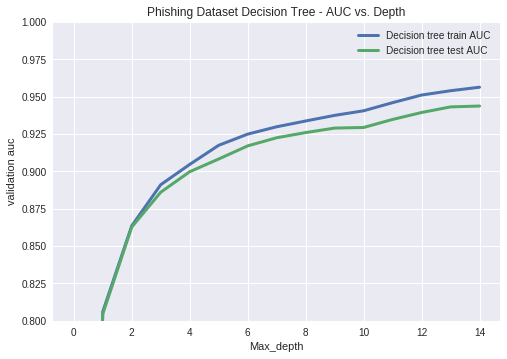

<Figure size 1152x576 with 0 Axes>

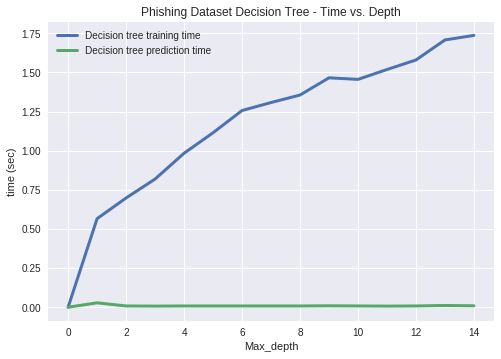

<Figure size 1152x576 with 0 Axes>

In [12]:
from matplotlib import pyplot
pyplot.plot(tree_auc_train, linewidth=3, label = "Decision tree train AUC")
pyplot.plot(tree_auc_test, linewidth=3, label = "Decision tree test AUC")
pyplot.legend()
pyplot.ylim(0.8, 1.0)
pyplot.title("Phishing Dataset Decision Tree - AUC vs. Depth")
pyplot.xlabel("Max_depth")
pyplot.ylabel("validation auc")
pyplot.figure(figsize=(16,8))
pyplot.savefig('Phishing_treedepth_fig2')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Decision tree training time")
pyplot.plot(prediction_time, linewidth=3, label = "Decision tree prediction time")
pyplot.legend()
pyplot.xlabel("Max_depth")
pyplot.ylabel("time (sec)")
pyplot.title("Phishing Dataset Decision Tree - Time vs. Depth")
pyplot.figure(figsize=(16,8))
pyplot.savefig('Phishing_treedepth_time_fig2')
pyplot.show()

In [13]:
print("Best tree depth training: " + str(np.argmax(tree_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(tree_auc_train, axis=0)))
print("Best tree depth testing: " + str(np.argmax(tree_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(tree_auc_test, axis=0)))

Best tree depth training: 14
Highest AUC score training: 0.9562550201618739
Best tree depth testing: 14
Highest AUC score testing: 0.9436717388153282


### Decision tree pruning


In [14]:
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

# plot_tree(clf, features)
# tree.export_graphviz(clf,out_file='tree.dot',class_names=['No','Yes'],feature_names=features, 
#                      filled=True, rounded=True, special_characters=True, proportion=True)
# os.system("dot -Tpng tree.dot -o tree.png")
# os.system("tree.png")
# # Note : Uncoverted Quotes (Yes) and Converted quotes (No)
# Image(filename='tree.png')


clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
clf_decision_tree = clf_decision_tree.fit(train_X, train_y)
prune_duplicate_leaves(clf_decision_tree)
    
tree_auc_train_pruned = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
tree_auc_test_pruned = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])

print("pruned decision tree training: " + str(tree_auc_train_pruned))
print("pruned decision tree testing: " + str(tree_auc_test_pruned))

# plot_tree(clf, features)
# tree.export_graphviz(clf,out_file='tree_pruned.dot',class_names=['No','Yes'],feature_names=features, 
#                          filled=True, rounded=True, special_characters=True, proportion=True)
# os.system("dot -Tpng tree_pruned.dot -o tree_pruned.png")
# os.system("tree_pruned.png")
# # Note : Uncoverted Quotes (Yes) and Converted quotes (No)
# Image(filename='tree_pruned.png')


pruned decision tree training: 0.9562550201618739
pruned decision tree testing: 0.9436717388153282


OK


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


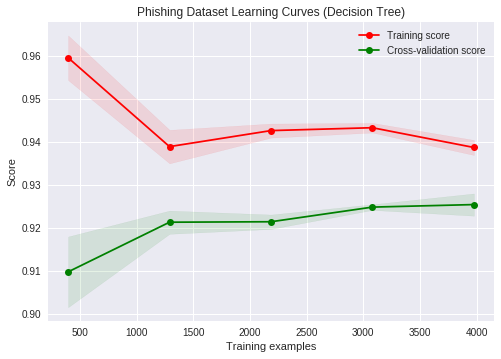

In [15]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt
  
print("OK")


X, y = train_X, train_y

title = "Phishing Dataset Learning Curves (Decision Tree)"
estimator = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy',random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

## Boosting


In [0]:
max_depth = 15
adaboost_auc_train, adaboost_auc_test = np.zeros(max_depth), np.zeros(max_depth)
training_time, prediction_time = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1,max_depth):
    clf_adaboost = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=i,criterion='entropy'), n_estimators=10, random_state=1)
    t0 = time.clock()
    clf_adaboost = clf_adaboost.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    adaboost_auc_train[i] = roc_auc_score(train_y, clf_adaboost.predict_proba(train_X)[:,1])
    t1 = time.clock()
    adaboost_auc_test[i] = roc_auc_score(test_y, clf_adaboost.predict_proba(test_X)[:,1])
    prediction_time[i] = round(time.clock()-t1, 3)
    


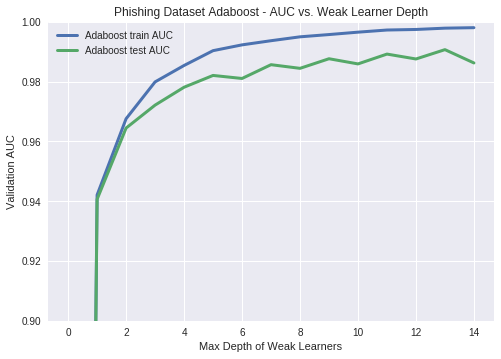

<Figure size 1152x576 with 0 Axes>

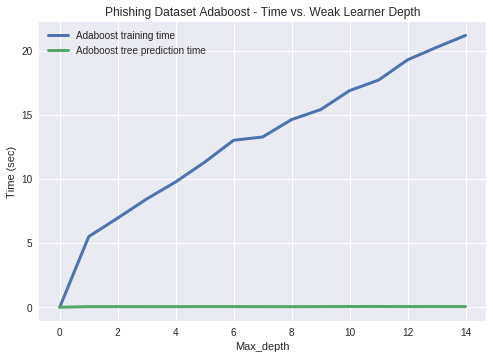

<Figure size 1152x576 with 0 Axes>

Best weak learner tree depth training: 14
Highest AUC score training: 0.9980419867147968
Best weak learner tree depth testing: 13
Highest AUC score testing: 0.9906936309254213


In [17]:
pyplot.plot(adaboost_auc_train, linewidth=3, label = "Adaboost train AUC")
pyplot.plot(adaboost_auc_test, linewidth=3, label = "Adaboost test AUC")
pyplot.legend()
pyplot.ylim(0.9, 1.0)
pyplot.xlabel("Max Depth of Weak Learners")
pyplot.ylabel("Validation AUC")
plt.title("Phishing Dataset Adaboost - AUC vs. Weak Learner Depth")
pyplot.figure(figsize=(16,8))
pyplot.savefig('Phishing_boosting_fig4')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Adaboost training time")
pyplot.plot(prediction_time, linewidth=3, label = "Adoboost tree prediction time")
pyplot.title("Phishing Dataset Adaboost - Time vs. Weak Learner Depth")
pyplot.legend()
pyplot.xlabel("Max_depth")
pyplot.ylabel("Time (sec)")
pyplot.figure(figsize=(16,8))
pyplot.savefig('Phishing_boosting_time_fig2')
pyplot.show()

print("Best weak learner tree depth training: " + str(np.argmax(adaboost_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(adaboost_auc_train, axis=0)))
print("Best weak learner tree depth testing: " + str(np.argmax(adaboost_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(adaboost_auc_test, axis=0)))

OK


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


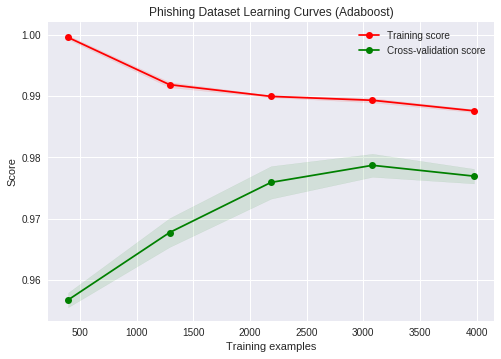

In [18]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
print("OK")


title = "Phishing Dataset Learning Curves (Adaboost)"
estimator = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=4,criterion='entropy', random_state=1), n_estimators=10,random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

## Neural Networks


In [28]:
learning_rate = [0.1, 1, 2,3]
training_time, prediction_time = [],[]
nn_auc_train, nn_auc_test = [],[]
for rate in learning_rate:
    clf_nn = MLPClassifier(learning_rate_init=rate, random_state=1)
    t0 = time.clock()
    clf_nn = clf_nn.fit(train_X, train_y)
    training_time.append(round(time.clock()-t0, 3))
    nn_auc_train.append(roc_auc_score(train_y, clf_nn.predict_proba(train_X)[:,1]))
    t1 = time.clock()
    nn_auc_test.append(roc_auc_score(test_y, clf_nn.predict_proba(test_X)[:,1]))
    prediction_time.append(round(time.clock()-t1, 3))



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


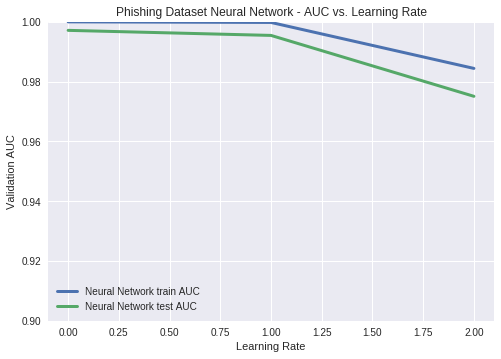

<Figure size 1152x576 with 0 Axes>

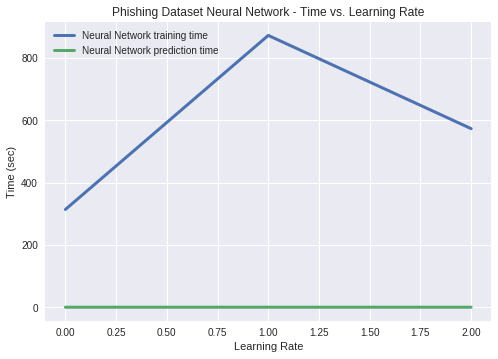

<Figure size 1152x576 with 0 Axes>

Best earning rate training: 0
Highest AUC score training: 0.9999913053456222
Best learning rate testing: 0
Highest AUC score testing: 0.997144721263681


In [29]:
pyplot.plot(nn_auc_train, linewidth=3, label = "Neural Network train AUC")
pyplot.plot(nn_auc_test, linewidth=3, label = "Neural Network test AUC")
pyplot.legend()
pyplot.ylim(0.9, 1.0)
pyplot.xlabel("Learning Rate")
pyplot.ylabel("Validation AUC")
plt.title("Phishing Dataset Neural Network - AUC vs. Learning Rate")
pyplot.figure(figsize=(16,8))
pyplot.savefig('Phishing_neural_network_fig')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Neural Network training time")
pyplot.plot(prediction_time, linewidth=3, label = "Neural Network prediction time")
pyplot.legend()
pyplot.xlabel("Learning Rate")
pyplot.ylabel("Time (sec)")
pyplot.title("Phishing Dataset Neural Network - Time vs. Learning Rate")
pyplot.figure(figsize=(16,8))
pyplot.savefig('Phishing_nn_time_fig')
pyplot.show()

print("Best earning rate training: " + str(np.argmax(nn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(nn_auc_train, axis=0)))
print("Best learning rate testing: " + str(np.argmax(nn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(nn_auc_test, axis=0)))

OK


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


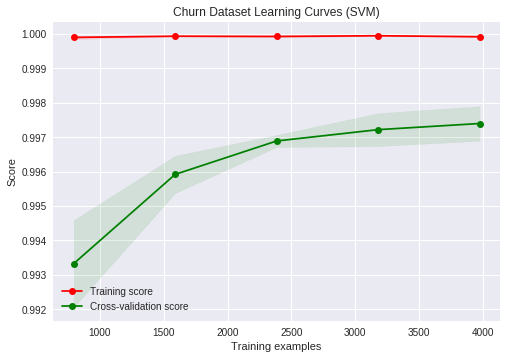

In [37]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.2, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, exploit_incremental_learning=True, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
print("OK")


title = "Phising Dataset Learning Curves (Neural Network)"
estimator = MLPClassifier(learning_rate_init=0.1, random_state=1)
cv = StratifiedKFold(n_splits=3,random_state=1, shuffle=False)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

## k-Nearest Neighbors


In [0]:
max_k = 5
knn_auc_train, knn_auc_test = np.zeros(max_k), np.zeros(max_k)
training_time, prediction_time = np.zeros(max_k), np.zeros(max_k)
for i in range(1,max_k):
    clf_knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
    t0 = time.clock()
    clf_knn = clf_knn.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    pred_train = clf_knn.predict_proba(train_X)[:,1]
    t1 = time.clock()
    pred_test = clf_knn.predict_proba(test_X)[:,1]
    prediction_time[i] = round(time.clock()-t1, 3)
    knn_auc_train[i] = roc_auc_score(train_y, pred_train)
    knn_auc_test[i] = roc_auc_score(test_y, pred_test)




    
    

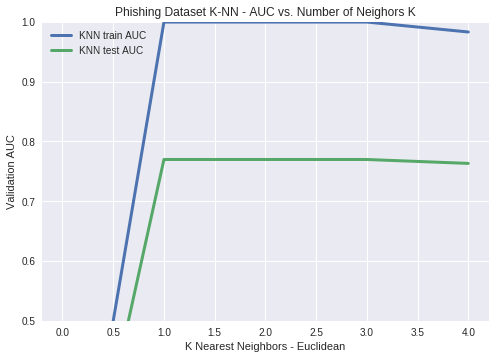

<Figure size 1152x576 with 0 Axes>

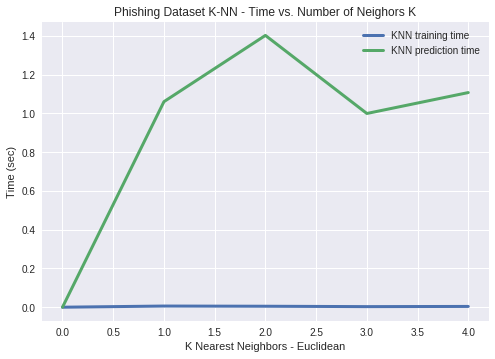

<Figure size 864x864 with 0 Axes>

Best number of neighbors training: 1
Highest AUC score training: 0.9996143463170073
Best number of neighbors testing: 1
Highest AUC score testing: 0.7697647512533745


In [23]:
pyplot.plot(knn_auc_train, linewidth=3, label = "KNN train AUC")
pyplot.plot(knn_auc_test, linewidth=3, label = "KNN test AUC")
pyplot.legend()
pyplot.ylim(0.5, 1.0)
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Validation AUC")
pyplot.title("Phishing Dataset K-NN - AUC vs. Number of Neighors K")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_knn_fig6')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "KNN training time")
pyplot.plot(prediction_time, linewidth=3, label = "KNN prediction time")
pyplot.legend()
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Time (sec)")
pyplot.title("Phishing Dataset K-NN - Time vs. Number of Neighors K")
pyplot.figure(figsize=(12,12))
pyplot.savefig('Phishing_Knn_time_fig')
pyplot.show()

print("Best number of neighbors training: " + str(np.argmax(knn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(knn_auc_train, axis=0)))
print("Best number of neighbors testing: " + str(np.argmax(knn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(knn_auc_test, axis=0)))

OK


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


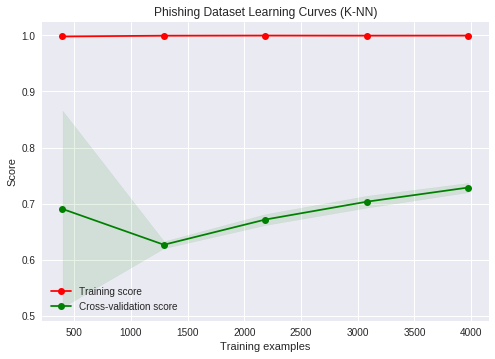

In [24]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
print("OK")


title = "Phishing Dataset Learning Curves (K-NN)"
estimator = KNeighborsClassifier(n_neighbors=1, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)
plt.show()

## Support Vector Machines (SVM)

In [31]:
clf_svm_linear = SVC(kernel='linear',probability=True, random_state=1)
t0 = time.clock()
clf_svm_linear.fit(train_X, train_y)
training_time_linear = round(time.clock()-t0, 3)
pred_train_linear = clf_svm_linear.predict_proba(train_X)[:,1]
t1 = time.clock()
pred_test_linear = clf_svm_linear.predict_proba(test_X)[:,1]
prediction_time_linear = round(time.clock()-t1, 3)
svm_auc_train_linear = roc_auc_score(train_y, pred_train_linear)
svm_auc_test_linear = roc_auc_score(test_y, pred_test_linear)

clf_svm_rbf = SVC(kernel='poly',probability=True, random_state=1)
t0 = time.clock()
clf_svm_rbf.fit(train_X, train_y)
training_time_rbf = round(time.clock() - t0, 3)
pred_train_rbf = clf_svm_rbf.predict_proba(train_X)[:,1]
t1= time.clock()
pred_test_rbf = clf_svm_rbf.predict_proba(test_X)[:,1]
prediction_time_rbf = round(time.clock() - t1, 3)
svm_auc_train_rbf = roc_auc_score(train_y, pred_train_rbf)
svm_auc_test_rbf = roc_auc_score(test_y, pred_test_rbf)

print("Linear kernel training AUC: " + str(svm_auc_train_linear))
print("Linear kernel testing AUC: " + str(svm_auc_test_linear))
print("Poly kernel training AUC: " + str(svm_auc_train_rbf))
print("Poly kernel testing AUC: " + str(svm_auc_test_rbf))

print("Linear kernel training time: " + str(training_time_linear))
print("Linear kernel prediction tim: " + str(prediction_time_linear))
print("Poly kernel training time: " + str(training_time_rbf))
print("Poly kernel prediction tim: " + str(prediction_time_rbf))
                             


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Linear kernel training AUC: 0.9999926781857871
Linear kernel testing AUC: 0.9978953216238456
Poly kernel training AUC: 0.7340917855765523
Poly kernel testing AUC: 0.6534901658310837
Linear kernel training time: 27.251
Linear kernel prediction tim: 4.147
Poly kernel training time: 101.077
Poly kernel prediction tim: 21.294


In [0]:
## Model Comparison

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


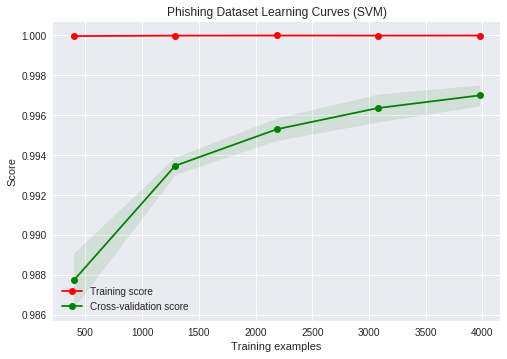

In [36]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Phishing Dataset Learning Curves (SVM)"
estimator = SVC(kernel='linear',probability=True, random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()
